# Actividad final

## Real Estate Sales 2001-2020 GL

### Descripción

The Office of Policy and Management maintains a listing of all real estate sales with a sales price of $2,000 or greater that occur between October 1 and September 30 of each year. For each sale record, the file includes: town, property address, date of sale, property type (residential, apartment, commercial, industrial or vacant land), sales price, and property assessment.

Data are collected in accordance with Connecticut General Statutes, section 10-261a and 10-261b: https://www.cga.ct.gov/current/pub/chap_172.htm#sec_10-261a and https://www.cga.ct.gov/current/pub/chap_172.htm#sec_10-261b.
Annual real estate sales are reported by grand list year (October 1 through September 30 each year). For instance, sales from 2018 GL are from 10/01/2018 through 9/30/2019.

https://catalog.data.gov/dataset/real-estate-sales-2001-2018

### Columnas del dataset

| **_Column Name_** | **_Description_**                                                                                                                                                                            | **_Type_**  |
|-------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|
| Serial Number     | Serial number                                                                                                                                                                                | Number      |
| List Year         | Year the property was listed for sale                                                                                                                                                        | Number      |
| Date Recorded     | Date the sale was recorded locally                                                                                                                                                           | Date & Time |
| Town              | Town name                                                                                                                                                                                    | Plain Text  |
| Address           | Address                                                                                                                                                                                      | Plain Text  |
| Assessed Value    | Value of the property used for local tax assesment                                                                                                                                           | Number      |
| Sale Amount       | Amount the property was sold for                                                                                                                                                             | Number      |
| Sales Ratio       | Ratio of the sale price to the assessed value                                                                                                                                                | Plain Text  |
| Property Type     | Type of property including: Residential, Commercial, Industrial, Apartments, Vacant, etc                                                                                                     | Plain Text  |
| Residential Type  | Indicates whether property is single or multifamily residential                                                                                                                              | Plain Text  |
| Non Use Code      | Non usable sale code typically means the sale price is not reliable for use in the determination of a property value. See attachments in the dataset description page for a listing of codes | Plain Text  |
| Assessor Remarks  | Remarks from the assessor                                                                                                                                                                    | Plain Text  |
| OPM remarks       | Remarks from OPM                                                                                                                                                                             | Plain Text  |
| Location          | Lat / lon coordinates                                                                                                                                                                        | Point       |

### Información adicional

Adjuntos importantes:
- [Non Usable Codes.pdf](https://data.ct.gov/api/views/5mzw-sjtu/files/21e4d34e-1117-43dd-a16e-06d9677ecb3f?download=true&filename=Non%20Usable%20Codes.pdf) : Documento que recoge las distintas categorías en las que se divide el campo _Non Use Code_

## Limpieza y preacondicionamiento de los datos

### Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Cargamos el dataset y vemos una muestra de los datos

In [37]:
# !wget -O "Real_Estate_Sales_2001-2020_GL.csv" "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"

In [38]:
data = pd.read_csv("Real_Estate_Sales_2001-2020_GL.csv", sep=',', low_memory=False)

In [39]:
data.sample(5)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
552582,90335,2009,03/02/2010,West Hartford,15 WEST RIDGE DR,271300.0,370000.0,0.733243,Single Family,Single Family,NaN,NaN,NaN,POINT (-72.74798 41.79207)
814632,16000185,2016,08/18/2017,Granby,87 HARTFORD AVE,47880.0,528000.0,0.090682,NaN,NaN,07 - Change in Property,INCOMPLETE ASSESSMENT,NaN,NaN
754892,150758,2015,07/27/2016,Manchester,450 EAST CENTER STREET,48500.0,58000.0,0.836207,Condo,Condo,NaN,NaN,NaN,NaN
21981,200354,2020,02/26/2021,Enfield,18 HARTFORD AVE,112600.0,193000.0,0.583400,Residential,Two Family,NaN,NaN,NaN,NaN
886919,170335,2017,04/02/2018,Wallingford,40 FOREST RD,126700.0,240000.0,0.527900,Single Family,Single Family,NaN,NaN,NaN,NaN


Este dataset no es precisamente pequeño, por lo que tarda un par de segundos en cargar

In [40]:
sys.getsizeof(data)/1e6

508.815832

In [41]:
data.shape

(997213, 14)

Veamos la estadística descriptiva que podemos obtener a priori sobre los datos

In [42]:
data.describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio
count,9.972130e+05,997213.000000,9.972130e+05,9.972130e+05,9.972130e+05
mean,4.311864e+05,2010.189829,2.791437e+05,3.911512e+05,1.044637e+01
std,6.549219e+06,6.237877,1.670610e+06,5.347270e+06,1.890192e+03
min,0.000000e+00,2001.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.044400e+04,2004.000000,8.760000e+04,1.400000e+05,4.867000e-01
50%,7.030300e+04,2010.000000,1.383900e+05,2.250000e+05,6.246000e-01
75%,1.518780e+05,2016.000000,2.255600e+05,3.650000e+05,7.852761e-01
max,2.000500e+09,2020.000000,8.815100e+08,5.000000e+09,1.226420e+06


Podemos observar de lo anterior que:
- El campo Serial Number comienza en 0 y termina en un número muy grande, puede significar que esta este campo puede servirnos como índice del dataset
- El dataset contiene información desde 2001 hasta 2020
- También podemos observar la media y desviación típica de las columnas respectivas a los valores de tasación y venta

Si observamos el número de valores únicos en el campo Serial Number podemos ver que no nos sirve como índice unívoco

In [43]:
data.shape[0] == data['Serial Number'].unique().shape[0]

False

Veamos qué tipo de datos tiene cada columna e información acerca de la completitud de los datos

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997211 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997162 non-null  object 
 5   Assessed Value    997213 non-null  float64
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     614767 non-null  object 
 9   Residential Type  608904 non-null  object 
 10  Non Use Code      289681 non-null  object 
 11  Assessor Remarks  149864 non-null  object 
 12  OPM remarks       9934 non-null    object 
 13  Location          197697 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 106.5+ MB


Respecto a la completitud de los datos podemos observar que la columna _OPM remarks_ cuenta con muy pocos valores informados respecto al total del dataset

In [45]:
data['OPM remarks'].unique()

array([nan, 'GAS STATION', 'GOOD SALE PER MLS', ..., 'INCLUDES #19158',
       'TOTAL RENOVATION PER MLS - SEE PREVIOUS SALE #1900075',
       'PER MLS CLOSING PRICE = $1,145,000'], dtype=object)

Igualmente será de poca ayuda pues no es información homogenea

In [46]:
data = data.drop('OPM remarks', axis=1)

Respecto al campo _Assesor Remarks_ que constituye el segundo con menos registros informados

In [47]:
data['Assessor Remarks'].unique()

array([nan, 'WATERFRONT/COTTAGE ONLY/LAND IS ASSOCIATION OWNED',
       'FORECLOSURE SALE OUT OF BANK', ..., 'FAMILY & FARM LAND',
       'FORECLOSURE BY SALE:  1-7-9-0', 'MOTIVATED SELLER -DIVORCE'],
      dtype=object)

Este campo se corresponde a una columna de comentarios igualmente poco homogenea

In [48]:
data = data.drop('Assessor Remarks', axis=1)

El campo _**Location**_ es muy interesante a pesar de tener sólo un 19% de completitud. Como contamos con las columnas _Address_ y _Town_ veamos si podemos hacer algo con él más adelante. De momento lo conservamos.

Veamos el campo _Non Use Code_, este campo resulta bastánte importante y será un campo que usaremos sobre todo para descartar registros. Como se indica en la descripción, este campo nos habla de transacciones que no debemos tener en cuenta en el estudio. Esto es porque tienen un sesgo específiico y en general un precio que no representa su valor real. Por ejemplo, tenemos el caso de **01 - Family** que se refiere a que ha sido una transacción entre dos miembros de la misma familia. Otro ejemplo claro es el **13 - Bankrupcy**, donde no se tiene un tipo de transacción normal.

In [49]:
data['Non Use Code'].unique()

array([nan, '08 - Part Interest', '14 - Foreclosure', '25 - Other',
       '01 - Family', '12 - Non Buildable Lot', '7', '8', '28', '24', '1',
       '07 - Change in Property', '25', '3', '18', '6', '17', '12', '2',
       '15', '24 - Plottage', '28 - Use Assessment', '09 - Tax',
       '18 - In Lieu Of Foreclosure', '06 - Portion of Property',
       '17 - Two Towns', '10 - A Will', '16 - Charitable Group',
       '26 - Rehabilitation Deferred', '15 - Government Agency',
       '02 - Love and Affection', '11 - Court Order',
       '03 - Inter Corporation', '22 - Money and Personal Property',
       'Single Family', '19 - Easement', '04 - Correcting Deed',
       '05 - Deed Date', '27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION',
       '13 - Bankrupcy', '30 - Auction',
       '21 - Personal Property Exchange', '23 - Zoning', '14',
       '20 - Cemetery', '29', '30', '19', '10', '11', '21', '4', '16',
       '29 - No Consideration', '13', '9', '22', '23', '5', '26', '33',
       '27', 

De esta forma y tal y como se nos indica en el documento anexo del dataset descartamos las filas que tienen este campo informado. Esto nos deja con un 30% menos de datos sobre los que trabajar.

In [50]:
data = data[data['Non Use Code'].isna()]
data = data.drop('Non Use Code', axis=1)
print(data.shape)

(707532, 11)


Analicemos ahora el _Property Type_

In [51]:
data['Property Type'].unique()

array(['Commercial', 'Residential', 'Vacant Land', nan, 'Apartments',
       'Industrial', 'Public Utility', 'Condo', 'Two Family',
       'Single Family', 'Three Family', 'Four Family'], dtype=object)

Este nos aporta bastánte información respecto al tipo de vivienda que es, veamos también el _Residential Type_

In [52]:
data['Residential Type'].unique()

array([nan, 'Single Family', 'Condo', 'Two Family', 'Three Family',
       'Four Family'], dtype=object)

Podemos observar como ambos campos son similares, de hecho el campo _Residential Type_ describe un poco más el inmueble cuando _Property Type_ es **Residential**. Veamos si podemos unirlos en uno

In [65]:
data[['Property Type','Residential Type']].sample(5, random_state=2)

,Property Type,Residential Type
194361,NaN,NaN
29275,Residential,Single Family
659030,Condo,Condo
213466,NaN,NaN
289047,NaN,NaN


En algunos casos difieren los valores, por ejemplo el caso de Residential y Single Family o el caso de Residential y Two Family. A continuación tenemos los casos concretos

In [66]:
mask1 = data['Property Type']!=data['Residential Type']
mask2 = ~(data['Property Type'][mask1]+data['Residential Type'][mask1]).isna()
display(data[['Property Type','Residential Type']][mask1][mask2].drop_duplicates())

,Property Type,Residential Type
1,Residential,Single Family
2,Residential,Condo
17,Residential,Two Family
156,Residential,Three Family
959,Residential,Four Family


De esta forma reemplazamos los valores del _Property type_ por los de _Residential Type_ en los casos que difieren

In [67]:
def _fill_values(row):
    not_nan = not pd.isna(row['Property Type']) and not pd.isna(row['Residential Type'])
    different = row['Property Type'] != row['Residential Type']
    PT_nan = pd.isna(row['Property Type'])
    RT_nan = pd.isna(row['Residential Type'])
    if (different and not_nan) or (PT_nan and not RT_nan):
        return row['Residential Type']
    else:
        return row['Property Type']

data['Property Type'] = data.apply(_fill_values, axis=1)
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 707532 entries, 0 to 997212
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     707532 non-null  int64  
 1   List Year         707532 non-null  int64  
 2   Date Recorded     707530 non-null  object 
 3   Town              707532 non-null  object 
 4   Address           707529 non-null  object 
 5   Assessed Value    707532 non-null  float64
 6   Sale Amount       707532 non-null  float64
 7   Sales Ratio       707532 non-null  float64
 8   Property Type     429569 non-null  object 
 9   Residential Type  426504 non-null  object 
 10  Location          143050 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 64.8+ MB


None

Con lo cual ya no necesitamos _Residential Type_

In [68]:
data = data.drop('Residential Type', axis=1)

Como es tan relevante la información contenida en _Property Type_ eliminamos las filas en las que este campo no viene informado y de esta forma ahora tenemos 429569 filas

In [69]:
data = data[~data['Property Type'].isna()]
print(data.shape)

(429569, 10)


Veamos nuevamente el campo _Location_, ¿habría alguna forma de poblar este campo?

Sabemos que en todos los casos tenemos el campo _Address_ y _Town_ informados. Esto nos puede llevar a la conclusión de que realmente podemos localizar de alguna forma las coordenadas de todas esas direcciones.

Para ello, tras investigar y buscar varias soluciones, encontramos la manera de deducir el _Location_ en función de los campos mencionados anteriormente. Esto lo haremos mediante la librería:

### Geolocalización
##### _**geopy**_

Enlaces de interés:
- [PyPI/geopy](https://pypi.org/project/geopy/)
- [github/geopy](https://github.com/geopy/geopy)


In [70]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myApp")

Primeramente preprocesamos y obtenemos la dirección completa

In [71]:
data['Full Address'] = data['Address']+','+data['Town']

Guardamos los datos filtrados para procesarlos

In [41]:
# data.to_csv("datos_filtrados", sep="|", index=False)

Usamos _geolocator.geocode_ para obtener toda la información, la mejor forma de hacerlo fue esta puesto que al hacerlo mediante un apply diréctamente nos rechaza la conexión

In [42]:
# # importing module
# import logging

# # Create and configure logger
# logging.basicConfig(filename="newfile.log",
# format='%(asctime)s %(message)s',
# filemode='w')

# # Creating an object
# logger = logging.getLogger()

# # Setting the threshold of logger to DEBUG
# logger.setLevel(logging.INFO)

In [43]:
# _marker = """
# ____________________________________________________________________________
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬

#                     NUEVA ENTRADA CON ERROR      %d

# ____________________________________________________________________________
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ############################################################################
# ¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬"""

In [44]:
# t_start = time.time()
# _loc_arr = [[0, 0]]*data.shape[0]
# try:
#     for i in range(199999+0+1,199999+25000+1,1):
#         if pd.isna(data.iloc[i]['Location']):
#             try:
#                 _loc_arr[i] = [i, geolocator.geocode(data.iloc[i]['Full Address'])]
#                 logging.info("-------------------> Terminada entrada %d"%i)
#             except Exception as e:
#                 logging.info(_marker%i)
#                 logging.info(e)
#             except KeyboardInterrupt:
#                 break
#             finally:
#                 continue
#         else:
#             logging.info(    "~~~~~~~~~~~~~~~~~~~> YA REGISTRADA entrada %d"%i)
#             _loc_arr[i] = [i, data.iloc[i]['Location']]
# except KeyboardInterrupt:
#     print("End")
# t_end = time.time()

In [45]:
# print(t_end-t_start)

In [46]:
# import pickle

# with open("Location_data_200000-224999", 'wb') as f:
#     pickle.dump(_loc_arr, f)

Tiempo en segundos (no es el proceso más eficiente, cuando ya lo teníamos ejecutando nos surgieron algunas mejoras y de hecho el try/except no funciona como se esperaba en el notebook):
- Location_data_400000-429569: 13925.821954727173
- Location_data_375000-399999: 11620.47594499588
- Location_data_350000-374999: 21029.55911707878
- Location_data_325000-349999: 20717.96820783615
- Location_data_300000-324999: 11376.085210323334
- Location_data_250000-299999: 40771.101276397705
- Location_data_250000-255999: 2237.9675166606903
- Location_data_240000-249999: 4528.234294176102
- Location_data_225000-239999: 6872.095524072647
- Location_data_200000-224999: 23180.915546178818
- Location_data_150000-199999: 27056.20046901703
- Location_data_100000-149999: 20612.415133953094
- Location_data_50000-99999: 20245.817759513855
- Location_data_00001-49999: 13785.730684041977

In [72]:
_t = """Location_data_400000-429569: 13925.821954727173
Location_data_375000-399999: 11620.47594499588
Location_data_350000-374999: 21029.55911707878
Location_data_325000-349999: 20717.96820783615
Location_data_300000-324999: 11376.085210323334
Location_data_250000-299999: 40771.101276397705
Location_data_250000-255999: 2237.9675166606903
Location_data_240000-249999: 4528.234294176102
Location_data_225000-239999: 6872.095524072647
Location_data_200000-224999: 23180.915546178818
Location_data_150000-199999: 27056.20046901703
Location_data_100000-149999: 20612.415133953094
Location_data_50000-99999: 20245.817759513855
Location_data_00001-49999: 13785.730684041977"""
_t = [ _tt.split(": ") for _tt in _t.split("\n")]
_temp = pd.DataFrame(_t, columns=['name','time_s'])
_temp['time_s'] = _temp['time_s'].astype(float)
_temp['time_m'] = _temp['time_s']/60
_temp['time_h'] = _temp['time_m']/60
_temp = _temp[['name','time_h']]

In [73]:
display(_temp)
print("Con un total de %d días y %d horas, sin contar con una primera prueba que falló de aproximadamente 1 día."%(_temp['time_h'].sum()//24, _temp['time_h'].sum()%24))

,name,time_h
0,Location_data_400000-429569,3.868284
1,Location_data_375000-399999,3.227910
2,Location_data_350000-374999,5.841544
3,Location_data_325000-349999,5.754991
4,Location_data_300000-324999,3.160024
5,Location_data_250000-299999,11.325306
6,Location_data_250000-255999,0.621658
7,Location_data_240000-249999,1.257843
8,Location_data_225000-239999,1.908915
9,Location_data_200000-224999,6.439143


Con un total de 2 días y 18 horas, sin contar con una primera prueba que falló de aproximadamente 1 día.


https://stackoverflow.com/questions/26951687/how-do-i-save-a-list-to-file-using-python

### Datos finales

Ver [Importar_archivos_de_location.ipynb](Importar_archivos_de_location.ipynb) donde se encuentra el proceso de ensamblado de los datos obtenidos.

In [74]:
fdata = pd.read_parquet('datos_finales')

In [75]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429569 entries, 0 to 429568
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Serial Number   429569 non-null  int64  
 1   List Year       429569 non-null  int64  
 2   Date Recorded   429569 non-null  object 
 3   Town            429569 non-null  object 
 4   Address         429568 non-null  object 
 5   Assessed Value  429569 non-null  float64
 6   Sale Amount     429569 non-null  float64
 7   Sales Ratio     429569 non-null  float64
 8   Property Type   429569 non-null  object 
 9   Full Address    429568 non-null  object 
 10  Longitude       347788 non-null  float64
 11  Latitude        347788 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 39.3+ MB


In [76]:
fdata.describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Longitude,Latitude
count,4.295690e+05,429569.000000,4.295690e+05,4.295690e+05,429569.000000,347788.000000,347788.000000
mean,7.399091e+05,2013.864769,2.618247e+05,3.976011e+05,0.672416,-72.823058,41.467885
std,8.937843e+06,4.588290,4.946971e+05,7.615301e+05,0.824367,3.598803,0.932568
min,8.200000e+01,2006.000000,0.000000e+00,0.000000e+00,0.000000,-161.761152,-44.459171
25%,7.019800e+04,2010.000000,1.182000e+05,1.800000e+05,0.579300,-73.063952,41.355267
50%,1.314920e+05,2014.000000,1.709000e+05,2.610000e+05,0.661194,-72.933610,41.359730
75%,1.803800e+05,2018.000000,2.650600e+05,4.000000e+05,0.747800,-72.721037,41.658591
max,2.000500e+09,2020.000000,1.106702e+08,1.540000e+08,529.776008,175.578497,60.794681


## Analisis

In [77]:
fdata.sample(6)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Full Address,Longitude,Latitude
94354,70382,2007,04/16/2008,East Hartford,54 PARK AVE,101470.0,156900.0,0.646718,Single Family,"54 PARK AVE,East Hartford",-72.933610,41.359730
382601,180663,2018,07/01/2019,Greenwich,453 EAST PUTNAM AVE 4E,431970.0,620000.0,0.696700,Condo,"453 EAST PUTNAM AVE 4E,Greenwich",-71.958455,41.781859
197881,120234,2012,12/27/2012,Greenwich,"81 LOCKWOOD ROAD, RIVERSIDE, C",727230.0,1100000.0,0.661118,Single Family,"81 LOCKWOOD ROAD, RIVERSIDE, C,Greenwich",NaN,NaN
96615,70167,2007,12/27/2007,Wallingford,1038 NORTH FARMS RD,220290.0,355000.0,0.620535,Single Family,"1038 NORTH FARMS RD,Wallingford",-72.781762,41.492244
215842,130299,2013,03/20/2014,Hamden,71 CONCORD ST,127330.0,200000.0,0.636650,Two Family,"71 CONCORD ST,Hamden",-72.933388,41.353013
114058,80497,2008,06/23/2009,West Hartford,44 MILDRED RD,174900.0,288000.0,0.607292,Single Family,"44 MILDRED RD,West Hartford",-72.756909,41.732332


Analicemos la correlación de las variables numéricas a priori

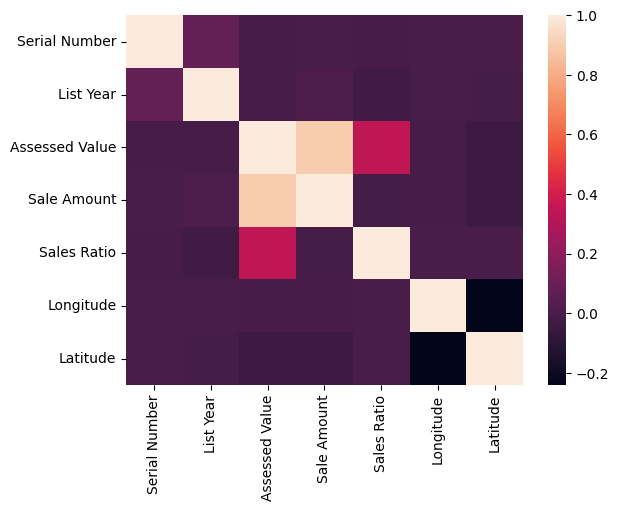

In [78]:
sns.heatmap(fdata.corr(numeric_only=True));

Como era de esperar la correlación nos arroja una relación entre variables que asocia a _Sale Amount_ y _Assessed Value_, esto es coherente puesto que mientras más tasación se tenga mayor valor tiene la propiedad y mayor será el importe de la venta

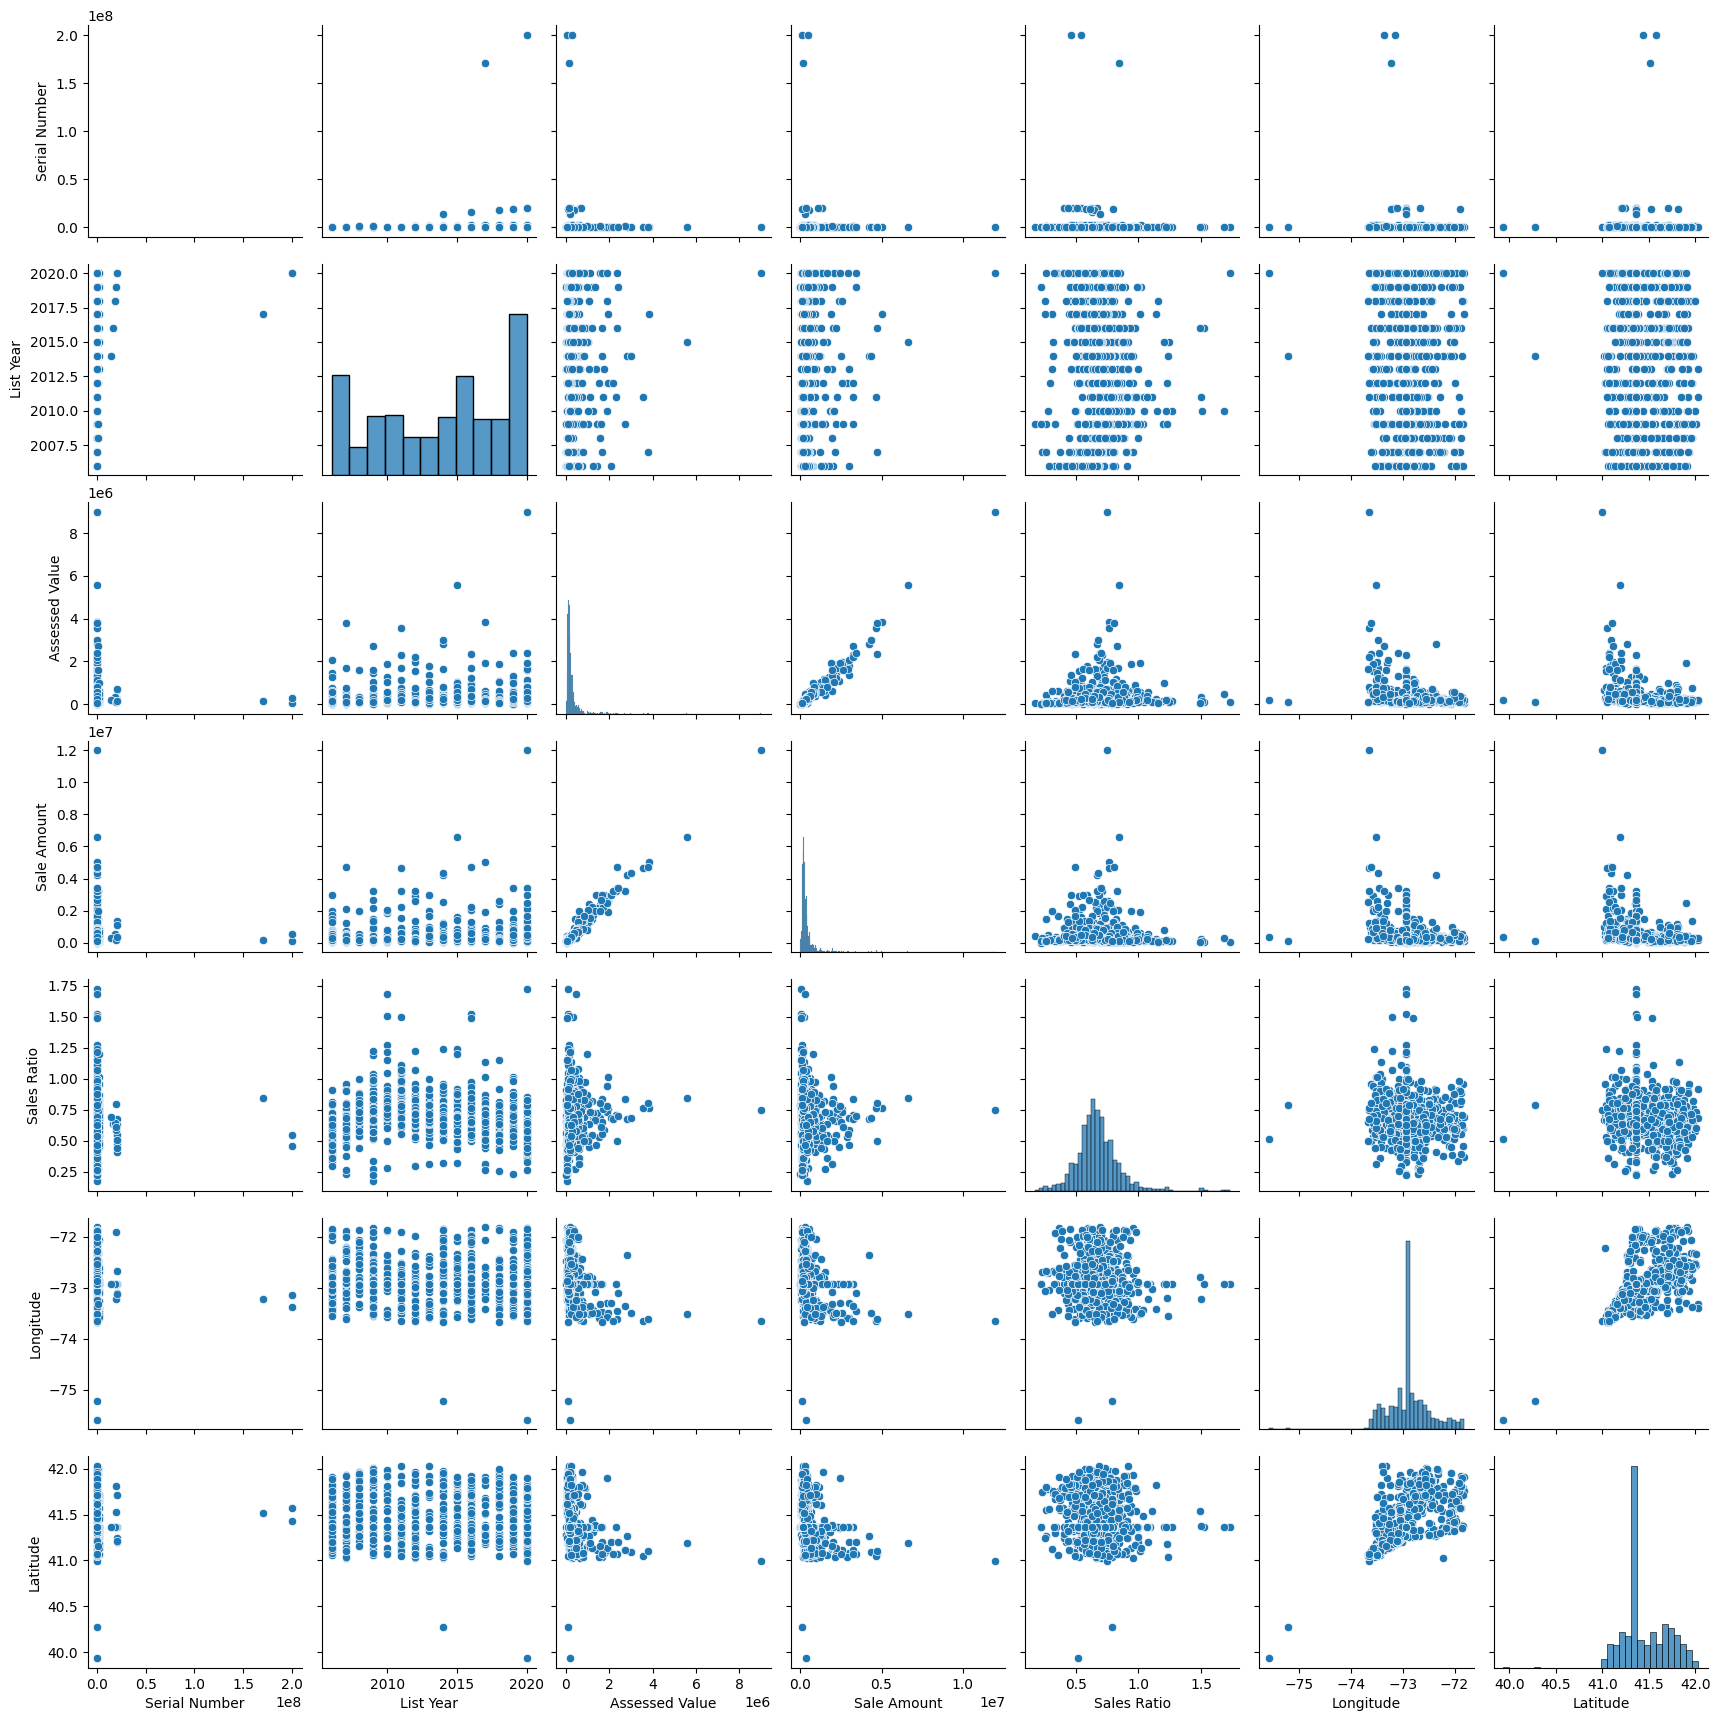

In [79]:
# tarda mucho en ejecutar, probablemente por la cantidad de datos, bajamos a una muestra de 1000
sns.pairplot(fdata.sample(1000));

Se puede sacar en claro, tal y como se vio en el mapa de calor, que el valor de tasación y el valor de venta se correlacionan muy bien y esta es aproximable a una lineal.

También podemos observar el que campo _Sales Ratio_ está relacionado con ambos puesto que constituye la división entre ambos

In [80]:
np.round((fdata['Assessed Value']/fdata['Sale Amount']).values[:50], 3)

array([0.463, 0.588, 0.725, 0.696, 0.596, 0.678, 0.608, 0.643, 0.512,
       0.48 , 0.655, 0.758, 0.7  , 0.578, 0.612, 0.581, 0.468, 0.657,
       0.557, 0.594, 0.574, 0.578, 0.597, 0.297, 0.571, 0.804, 0.639,
       0.583, 0.75 , 1.748, 0.555, 0.674, 0.644, 0.617, 0.791, 0.517,
       0.217, 0.488, 0.366, 0.503, 0.402, 0.795, 0.387, 0.55 , 0.776,
       0.566, 0.509, 0.452, 0.543, 0.551])

In [81]:
np.round(fdata['Sales Ratio'].values[:50], 3)

array([0.463, 0.588, 0.725, 0.696, 0.596, 0.678, 0.608, 0.643, 0.511,
       0.48 , 0.655, 0.758, 0.7  , 0.578, 0.612, 0.581, 0.468, 0.657,
       0.557, 0.594, 0.574, 0.578, 0.597, 0.297, 0.571, 0.804, 0.639,
       0.583, 0.75 , 1.748, 0.555, 0.674, 0.644, 0.616, 0.791, 0.517,
       0.217, 0.488, 0.366, 0.503, 0.402, 0.795, 0.387, 0.55 , 0.776,
       0.566, 0.509, 0.452, 0.543, 0.551])

Dejamos este campo puesto que nos puede servir en algún momento del análisis pero sabiendo que no nos será de utilidad como **feature** para predecir el precio de venta puesto que él, en sí mismo, involucra al precio de venta

Podemos usar también las variables categóricas para analizar los datos. Veamos, por ejemplo, el top 20 de valor medio de ventas por ciudad (pues hay 169 ciudades).

In [82]:
fdata['Town'].nunique()

169

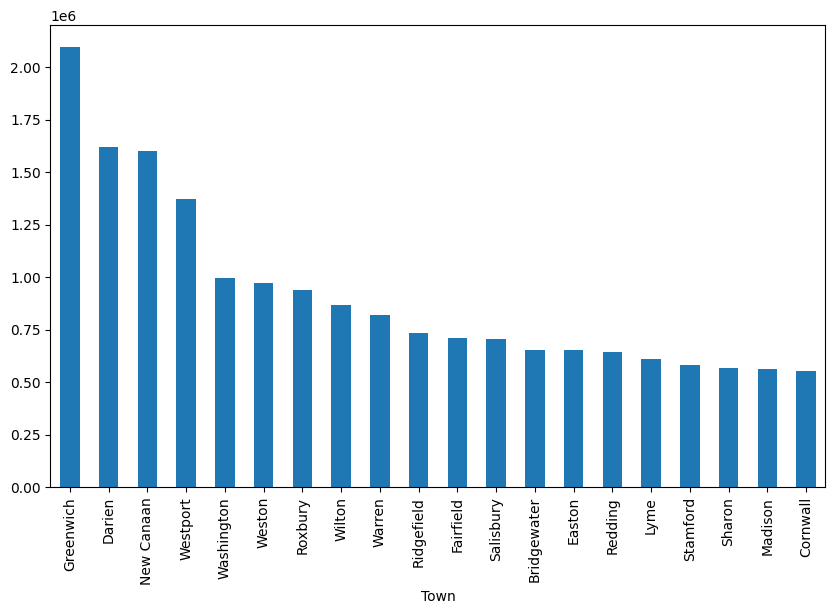

In [83]:
gb_00 = fdata.groupby(by=['Town'])['Sale Amount'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(1,1, figsize=(10,6))
gb_00[:20].plot(kind='bar', ax=ax);

¿Y las 10 ciudades con menor media?

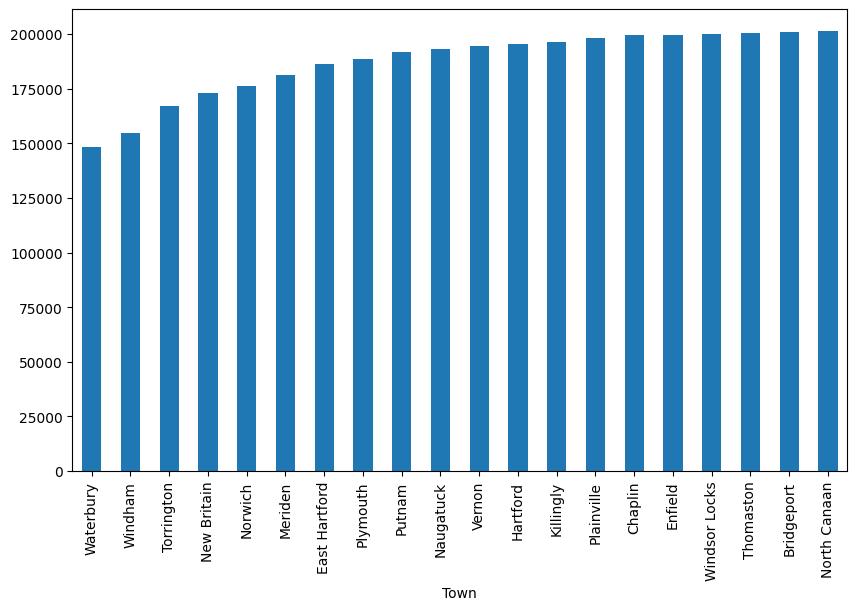

In [84]:
gb_01 = fdata.groupby(by=['Town'])['Sale Amount'].mean().sort_values(ascending=True)
fig, ax = plt.subplots(1,1, figsize=(10,6))
gb_01[:20].plot(kind='bar');

¿Y para el Valor Tasado (_Assessed Value_)?

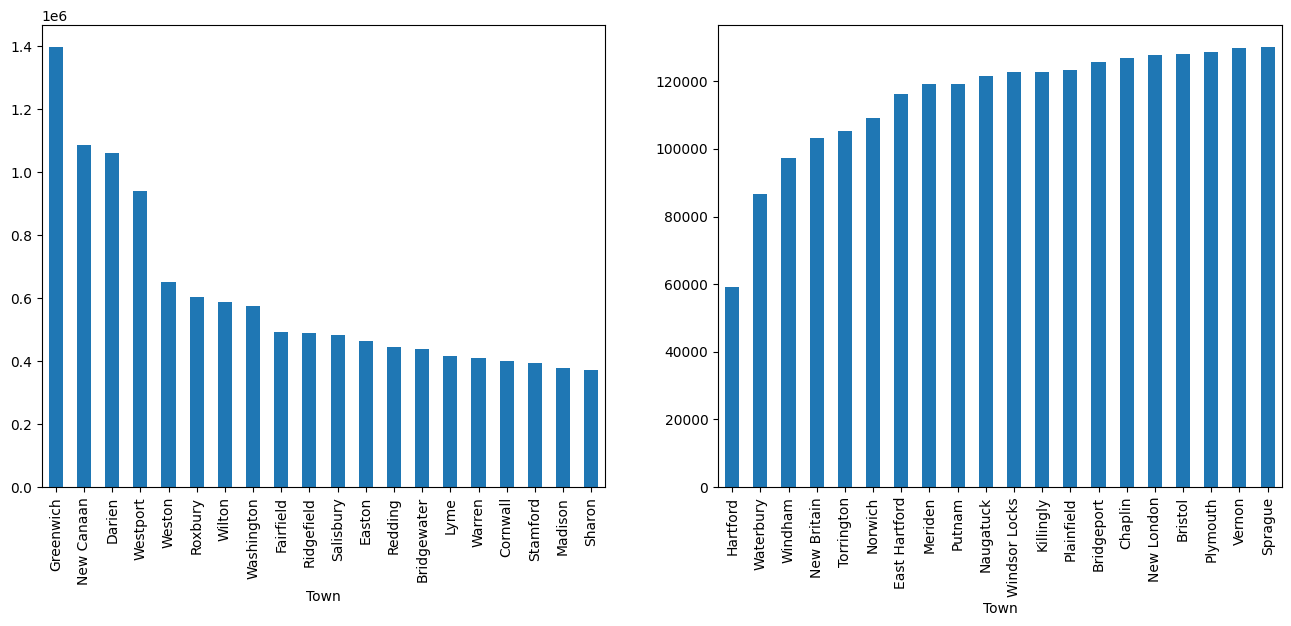

In [85]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
gb_00 = fdata.groupby(by=['Town'])['Assessed Value'].mean().sort_values(ascending=False)
gb_00[:20].plot(kind='bar', ax=ax[0]);
gb_01 = fdata.groupby(by=['Town'])['Assessed Value'].mean().sort_values(ascending=True)
gb_01[:20].plot(kind='bar', ax=ax[1]);

E incluso para el ratio $\frac{valor\ tasado}{valor\ de\ venta}$ (_'Sales Ratio'_)

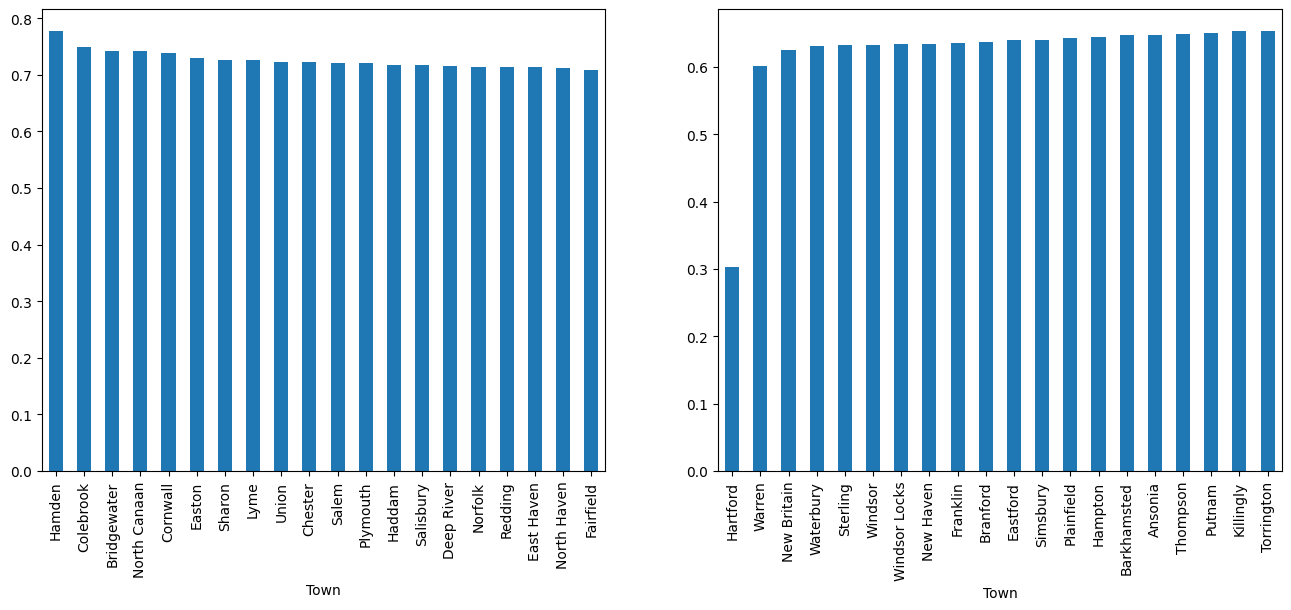

In [86]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
gb_00 = fdata.groupby(by=['Town'])['Sales Ratio'].mean().sort_values(ascending=False)
gb_00[:20].plot(kind='bar', ax=ax[0]);
gb_01 = fdata.groupby(by=['Town'])['Sales Ratio'].mean().sort_values(ascending=True)
gb_01[:20].plot(kind='bar', ax=ax[1]);

Por lo tanto vemos que, por ejemplo, en "Hamden" el precio tasado se asemeja bastánte al precio de venta.

Veamos también el precio medio por tipo de propiedad, por ejemplo, en "Hamden"

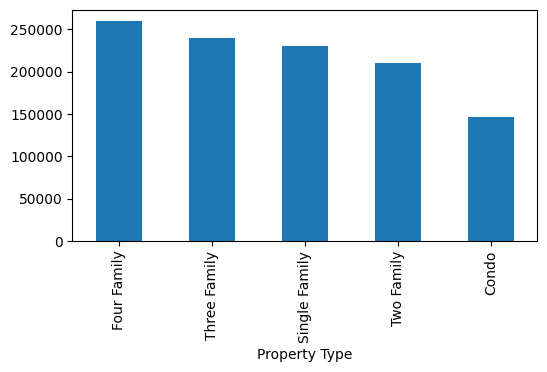

In [87]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
mask = fdata['Town']=="Hamden"
gb_02 = fdata[mask].groupby(by=['Property Type'])['Sale Amount'].median().sort_values(ascending=False)
gb_02.plot(kind='bar', ax=ax);

También podemos ver, tomando "Hamden" como ejemplo la evolución temporal de la media anual (usando el año en el que se pusieron a la venta) de los precios de venta.

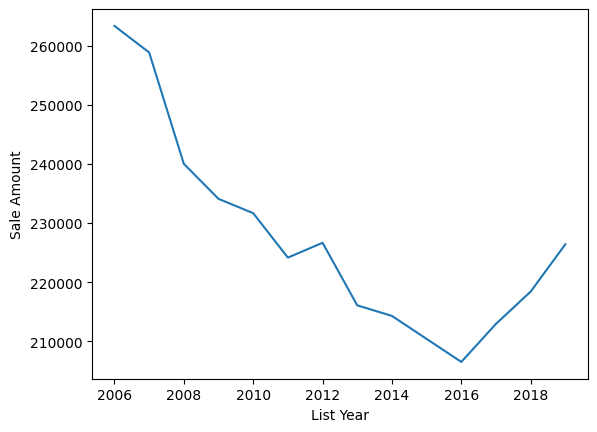

In [88]:
mask = fdata['Town']=="Hamden"
gb_03 = fdata[mask].groupby('List Year')[['Sale Amount']].mean()
sns.lineplot(data=gb_03.reset_index(), x='List Year', y='Sale Amount')
plt.show()

Vemos que hubo una recesión en los precios hasta que finalmente se comenzaron a recuperar.

### Geolocalización

Podemos utilizar los datos geográficos que tenemos para poder tener una idea de la distribución geográfica de los datos por año. Veamos a priori la representación de todos los datos.

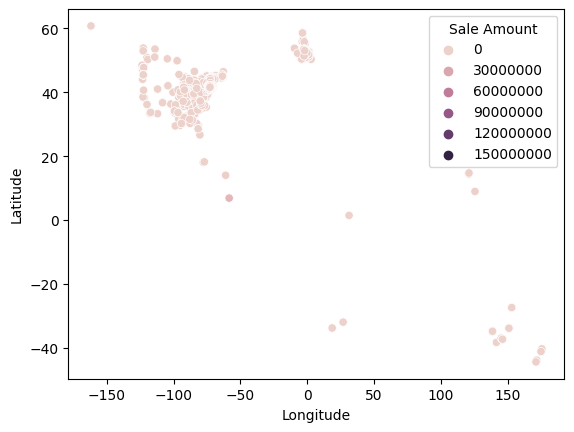

In [89]:
sns.scatterplot(data=fdata, x='Longitude', y='Latitude', hue='Sale Amount');

Descartemos los que se alejan de los clusteres de datos. Parece que los signos están invertidos en estos casos (por lo simétrica de la representación) de todas formas los descartamos. De esta forma nos quedamos sólo con los datos correspondientes a EEUU.

![image.png](captura-de-pantalla-2017-09-21-a-las-10-17-48.png)

In [164]:
ffdata = fdata.copy()
mask = (((ffdata['Longitude'] <= -50) & (ffdata['Longitude'] >= -150))
        & ((ffdata['Latitude'] >= 20) & (ffdata['Latitude'] <= 60)))
ffdata = ffdata[mask]

In [165]:
ffdata['Sold Year'] = pd.to_datetime(ffdata['Date Recorded']).apply(lambda x: x.year)
ffdata['Sold Month'] = pd.to_datetime(ffdata['Date Recorded']).apply(lambda x: x.month)
ffdata['Sold Day'] = pd.to_datetime(ffdata['Date Recorded']).apply(lambda x: x.day)

Primeramente quitamos los datos que no cumplan que _List Year_ <= _Sold Year_

In [166]:
ffdata = ffdata[ffdata['List Year'] <= ffdata['Sold Year']]

In [167]:
ffdata['Sold Year'].unique()

array([2020, 2021, 2007, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019], dtype=int64)

Veamos algunos años.

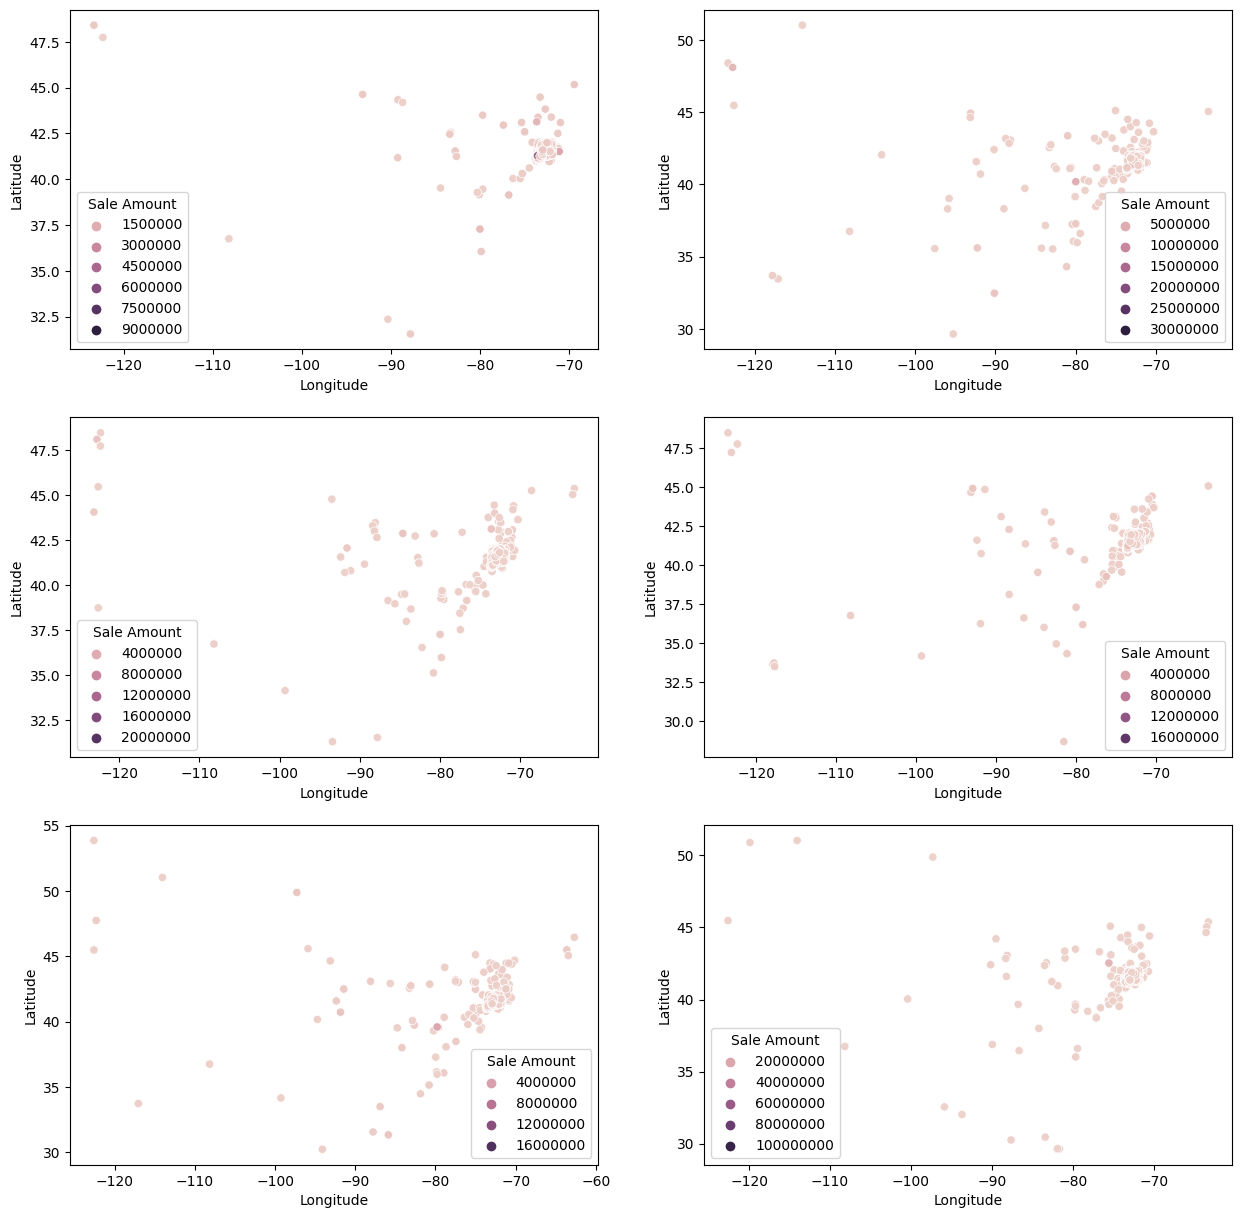

In [168]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
mask = ffdata['Sold Year']==2006
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[0,0])
mask = ffdata['Sold Year']==2008
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[0,1])
mask = ffdata['Sold Year']==2010
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[1,0])
mask = ffdata['Sold Year']==2015
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[1,1])
mask = ffdata['Sold Year']==2019
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[2,0])
mask = ffdata['Sold Year']==2021
sns.scatterplot(data=ffdata[mask], x='Longitude', y='Latitude', hue='Sale Amount', ax=ax[2,1])
plt.show()

Parece que el número de ventas registradas ha aumentado con los años (los primeros registros hasta 2005 eran erroneos pues _List Year_ > _Sold Year_) y que gran parte de los datos es de la zona Este de EEUU.

Partiendo de lo anterior veamos el número de ventas registradas por año (usando el año de venta).

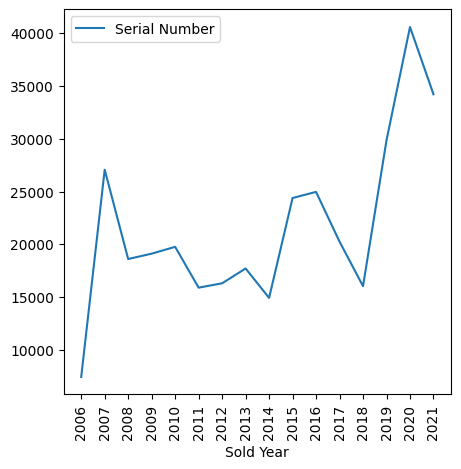

In [169]:
gb_04 = ffdata.groupby('Sold Year')[['Serial Number']].count()
fig, ax = plt.subplots(1,1, figsize=(5,5))
gb_04.plot(kind='line', xticks=ffdata['Sold Year'].unique(), ax=ax)
plt.xticks(rotation=90)
plt.show()

Efectivamente en los primeros años hay muy pocos valores y el máximo es en 2020.

Podemos comparar también el año de venta y el año en el que se puso en venta la vivienda.

In [170]:
(ffdata['Sold Year']-ffdata['List Year']).median()

1.0

Export for plotly

In [171]:
# ffdata.to_parquet('datos_para_plotly')

### Preparación para ajustar a un modelo de regresión

Primeramente veamos el los campos de coordenadas.

In [172]:
ffdata[['Longitude', 'Latitude']].describe()

,Longitude,Latitude
count,347309.000000,347309.000000
mean,-72.931465,41.463690
std,1.239936,0.341063
min,-123.514399,26.657912
25%,-73.064393,41.355095
50%,-72.933610,41.359730
75%,-72.722481,41.657735
max,-62.680697,53.865871


Parece que hay valores que se alejan mucho de la media.

Visto en Plotly con la función:

```python
import plotly.graph_objects as go

import pandas as pd

df = pd.read_parquet("Analisis/datos_para_plotly")
df.head(3)

df['text'] = df['Town'] \
    + '<br>Sales: $' + (df['Sale Amount']).astype(str) \
    + '<br>Type: ' + df['Property Type']
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 5000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Sale Amount']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'Sales in 2020<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)'
        )
    )

fig.show()
```

Se puede observar que los datos pertenecen a [_Connecticut, USA_](https://www.latlong.net/place/connecticut-usa-27708.html), con lo cual, como última operación de data cleansing eliminaremos los datos que se salgan de este estado.

- [List of extreme latitudes and longitudes for each US state?](https://gis.stackexchange.com/questions/386722/list-of-extreme-latitudes-and-longitudes-for-each-us-state)
    - [Bounding box of states in USA from OSM's Nominatim](https://gist.github.com/mishari/5ecfccd219925c04ac32)
    - [Bounding Boxes for All US States](https://anthonylouisdagostino.com/bounding-boxes-for-all-us-states/)

In [173]:
dCon = {"boundingbox":["40.9667053222656","42.0505905151367","-73.7277755737305","-71.7869873046875"],"lat":"41.493929","lon":"-72.5982114"}
for i,f in enumerate(dCon['boundingbox']):
    dCon['boundingbox'][i] = float(f)
display(dCon)

{'boundingbox': [40.9667053222656,
  42.0505905151367,
  -73.7277755737305,
  -71.7869873046875],
 'lat': '41.493929',
 'lon': '-72.5982114'}

In [174]:
mask = ( (ffdata['Longitude']>=dCon['boundingbox'][2]) & ((ffdata['Longitude']<=dCon['boundingbox'][3]))
& (ffdata['Latitude']>=dCon['boundingbox'][0]) & ((ffdata['Latitude']<=dCon['boundingbox'][1])) )
ffdata = ffdata[mask]
display(ffdata.sample(3))

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Full Address,Longitude,Latitude,Sold Year,Sold Month,Sold Day
221772,130393,2013,06/03/2014,Manchester,39 CAMBRIDGE STREET,100500.0,198000.0,0.507576,Single Family,"39 CAMBRIDGE STREET,Manchester",-72.525394,41.784755,2014,6,3
36103,200081,2020,11/30/2020,New London,778 OCEAN AVE,259370.0,379000.0,0.684300,Single Family,"778 OCEAN AVE,New London",-72.100090,41.323163,2020,11,30
159495,90004,2009,10/02/2009,Southbury,124 BRIDLE PATH RD,273390.0,345000.0,0.792435,Condo,"124 BRIDLE PATH RD,Southbury",-73.168368,41.469306,2009,10,2


Ahora contamos con unos datos listos para preparar.

In [175]:
ffdata[(ffdata['Sold Year']==2019)|(ffdata['Sold Year']==2020)|(ffdata['Sold Year']==2021)].describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Longitude,Latitude,Sold Year,Sold Month,Sold Day
count,1.042200e+05,104220.000000,1.042200e+05,1.042200e+05,104220.000000,104220.000000,104220.000000,104220.000000,104220.000000,104220.000000
mean,2.061221e+06,2019.252994,2.652841e+05,4.342341e+05,0.611424,-72.887438,41.452077,2020.042094,6.722203,15.477855
std,1.526484e+07,0.771636,6.028271e+05,1.034978e+06,0.170710,0.340212,0.212203,0.781275,3.142806,9.142508
min,1.901000e+03,2017.000000,1.715000e+03,2.000000e+03,0.042500,-73.715729,40.971141,2019.000000,1.000000,1.000000
25%,1.805200e+05,2019.000000,1.134000e+05,1.975000e+05,0.530200,-72.977644,41.359730,2019.000000,4.000000,7.000000
50%,1.905960e+05,2019.000000,1.668800e+05,2.825000e+05,0.602200,-72.933610,41.359730,2020.000000,7.000000,16.000000
75%,2.005460e+05,2020.000000,2.638850e+05,4.300000e+05,0.675580,-72.771601,41.584120,2021.000000,9.000000,23.000000
max,2.020003e+08,2020.000000,8.788848e+07,1.050000e+08,22.413300,-71.789032,42.049413,2021.000000,12.000000,31.000000


#### Tomando los años 2019, 2020, 2021

Tomemos los tres últimos años para alimentar al modelo `2019, 2020 y 2021`. Eliminamos el campo _Serial Number_, los campos de fecha de venta puesto que no se saben a priori y los campos de direcciones puesto que ya no nos hacen falta. Eliminamos el _Sales Ratio_ pues tampoco .Podemos quitar el año en que se pusieron a la venta pero a priori dejémoslo.

In [249]:
mask=(ffdata['Sold Year']==2019)|(ffdata['Sold Year']==2020)|(ffdata['Sold Year']==2021)
dataset = ffdata[mask].drop(['Serial Number','Date Recorded', 'Town', 'Address',
              'Sales Ratio','Full Address', 'Sold Year', 'Sold Month','Sold Day'], axis=1)
dataset.sample(3)

,List Year,Assessed Value,Sale Amount,Property Type,Longitude,Latitude
27154,2020,565570.0,963500.0,Single Family,-72.933610,41.359730
413223,2019,73900.0,115000.0,Condo,-72.829000,41.826197
11243,2020,110580.0,220000.0,Single Family,-72.588635,41.999559


In [250]:
# dataset = pd.get_dummies(ffdata)
dataset = pd.get_dummies(dataset)
display(dataset.sample(3))

,List Year,Assessed Value,Sale Amount,Longitude,Latitude,Property Type_Apartments,Property Type_Commercial,Property Type_Condo,Property Type_Four Family,Property Type_Industrial,Property Type_Public Utility,Property Type_Single Family,Property Type_Three Family,Property Type_Two Family,Property Type_Vacant Land
393434,2019,208440.0,390000.0,-73.056002,41.536350,False,False,False,False,False,False,True,False,False,False
368288,2018,85990.0,171000.0,-72.933610,41.359730,False,False,False,False,False,False,True,False,False,False
395332,2019,164600.0,325000.0,-72.569501,41.672125,False,False,True,False,False,False,False,False,False,False


In [251]:
dataset.shape

(104220, 15)

In [252]:
X = dataset[['List Year', 'Assessed Value', 'Longitude', 'Latitude',
       'Property Type_Apartments', 'Property Type_Commercial',
       'Property Type_Condo', 'Property Type_Four Family',
       'Property Type_Industrial', 'Property Type_Public Utility',
       'Property Type_Single Family', 'Property Type_Three Family',
       'Property Type_Two Family', 'Property Type_Vacant Land']].values
display(X)

array([[2020, 253000.0, -72.20731, ..., False, False, False],
       [2020, 130400.0, -72.8759407, ..., False, False, False],
       [2020, 619290.0, -72.9025616, ..., False, False, False],
       ...,
       [2019, 125230.0, -72.93361, ..., False, False, False],
       [2019, 121450.0, -72.6554538, ..., False, False, False],
       [2019, 203360.0, -72.7013756, ..., False, False, False]],
      dtype=object)

In [253]:
y = dataset['Sale Amount'].values
display(y)

array([430000., 179900., 890000., ..., 246000., 210000., 280000.])

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [255]:
reg = LinearRegression().fit(X_train, y_train)

In [256]:
reg.score(X_test, y_test)

0.8493301789300408

Probemos a predecir

In [257]:
np.random.seed(111)
n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))
np.random.seed(11)

print("\n")

n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))

Predicción:  1595303.66367691
Valor real:  1600000.0
----------> Diferencia(%):  0.2935210201931186


Predicción:  208771.11417414993
Valor real:  195000.0
----------> Diferencia(%):  6.596273736730899


#### Tomando un solo año, el 2021

In [259]:
mask=(ffdata['Sold Year']==2021)
dataset = ffdata[mask].drop(['Serial Number','Date Recorded', 'Town', 'Address',
              'Sales Ratio','Full Address', 'Sold Year', 'Sold Month','Sold Day'], axis=1)
print(dataset.shape)
print("\n")

dataset = pd.get_dummies(dataset)

X = dataset[['List Year', 'Assessed Value', 'Longitude', 'Latitude',
       'Property Type_Apartments', 'Property Type_Commercial',
       'Property Type_Condo', 'Property Type_Four Family',
       'Property Type_Industrial', 'Property Type_Public Utility',
       'Property Type_Single Family', 'Property Type_Three Family',
       'Property Type_Two Family', 'Property Type_Vacant Land']].values
y = dataset['Sale Amount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

print("Score: ",reg.score(X_test, y_test))
print("\n")

np.random.seed(111)
n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))
np.random.seed(11)

print("\n")

n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))

(34093, 6)


Score:  0.8850451552540454


Predicción:  326169.1277883941
Valor real:  305000.0
----------> Diferencia(%):  6.490230369726413


Predicción:  256431.41628359194
Valor real:  250000.0
----------> Diferencia(%):  2.508045377903044


Vemos como la preción mejora

#### Descartando la columna de _List Year_

No aporta ningún cambio reseñable al ajuste.

In [265]:
mask=(ffdata['Sold Year']==2021)
dataset = ffdata[mask].drop(['List Year', 'Serial Number','Date Recorded', 'Town', 'Address',
              'Sales Ratio','Full Address', 'Sold Year', 'Sold Month','Sold Day'], axis=1)
print(dataset.shape)
print("\n")

dataset = pd.get_dummies(dataset)

X = dataset[['Assessed Value', 'Longitude', 'Latitude',
       'Property Type_Apartments', 'Property Type_Commercial',
       'Property Type_Condo', 'Property Type_Four Family',
       'Property Type_Industrial', 'Property Type_Public Utility',
       'Property Type_Single Family', 'Property Type_Three Family',
       'Property Type_Two Family', 'Property Type_Vacant Land']].values
y = dataset['Sale Amount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

print("Score: ",reg.score(X_test, y_test))
print("\n")

np.random.seed(111)
n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))
np.random.seed(11)

print("\n")

n = np.random.randint(y_test.shape[0])
_pred = reg.predict(X_test[n].reshape(1,-1))[0]
_real = y_test[n]
print("Predicción: ", _pred)
print("Valor real: ", _real)
print("----------> Diferencia(%): ", 100*np.abs(_pred-_real)/np.max([_pred,_real]))

(34093, 5)


Score:  0.8850451552540454


Predicción:  326169.12778839405
Valor real:  305000.0
----------> Diferencia(%):  6.490230369726396


Predicción:  256431.41628359252
Valor real:  250000.0
----------> Diferencia(%):  2.508045377903265


### Uso de XGBoost como alternativa prometedora

_"XGBoost es un método de aprendizaje automático supervisado para clasificación y regresión y se utiliza en la herramienta Entrenar con AutoML. XGBoost es la abreviatura de las palabras inglesas "extreme gradient boosting" (refuerzo de gradientes extremo). Este método se basa en árboles de decisión y supone una mejora sobre otros métodos, como el bosque aleatorio y refuerzo de gradientes. Funciona bien con datasets grandes y complejos al utilizar varios métodos de optimización."_

Enlances:
- [Cómo funciona el algoritmo XGBoost](https://pro.arcgis.com/es/pro-app/latest/tool-reference/geoai/how-xgboost-works.htm)
- [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/index.html)